<a href="https://colab.research.google.com/github/pakdaniel/DataMiningFinal/blob/main/DataMiningFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pysofaconventions
!pip3 install colorama

     |████████████████████████████████| 89 kB 5.9 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np 
import random
import matplotlib.pyplot as plt
import os 
import sys
import librosa
import librosa.display
import pysofaconventions 
import colorama
from warnings import warn
from IPython.display import Audio, display

SEED = 1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
drive_root = '/content/drive'
drive.mount(drive_root)

HUTUBS_PATH = os.path.join(drive_root, "My Drive", "HUTUBS")
HRIR_DIR = os.path.join(HUTUBS_PATH, "HRIRs")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class SOFA:
  def __init__(self, obj):

    self.IR = obj.getDataIR().data
    self.SamplingRate = obj.getSamplingRate().data.item()
    self.SamplingRateUnits = obj.getSamplingRateUnits()
    self.Delay = obj.getDataDelay().data
      
    dim_dict = obj.getDimensionsAsDict()
    self.M = dim_dict["M"].size # Num measurement positions
    self.R = dim_dict["R"].size # Num receivers (ears)
    self.E = dim_dict["E"].size # Num emitters (speakers)
    self.N = dim_dict["N"].size # Length of HRTF
    self.I = dim_dict["I"].size 
    self.S = dim_dict["S"].size

    self.Listener = {
        "Position": obj.getListenerPositionValues().data,
        "PositionType": obj.getListenerPositionInfo()[1],
        "PositionUnits": obj.getListenerPositionInfo()[0],
        "Up": obj.getListenerUpValues().data,
        "View": obj.getListenerViewValues().data,
        "ViewType": obj.getListenerViewInfo()[1],
        "ViewUnits": obj.getListenerViewInfo()[0],
    }

    self.Receiver = {
        "Position": obj.getReceiverPositionValues().data,
        "PositionType": obj.getReceiverPositionInfo()[1],
        "PositionUnits": obj.getReceiverPositionInfo()[0],
    }

    self.Source = {
        "Position": obj.getSourcePositionValues().data,
        "PositionType": obj.getSourcePositionInfo()[1],
        "PositionUnits": obj.getSourcePositionInfo()[0],
    }

    self.Emitter = {
        "Position": obj.getEmitterPositionValues().data,
        "PositionType": obj.getEmitterPositionInfo()[1],
        "PositionUnits": obj.getEmitterPositionInfo()[0],
    }

  @staticmethod
  def sph2cart(coords):
      alpha = coords[:, 0]*(np.pi/180)
      beta = coords[:, 1]*(np.pi/180)
      r = coords[:, 2]

      x = r * np.cos(alpha) * np.cos(beta)
      y = r * np.sin(alpha) * np.cos(beta)
      z = r * np.sin(beta)
      return np.array([x, y, z]).T

  @staticmethod
  def cart2sph(coords):
      x = coords[:, 0]
      y = coords[:, 1]
      z = coords[:, 2]
      
      r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
      alpha = np.arctan2(y, x)
      beta = np.arcsin(z / np.where(r != 0, r, 1))
      return alpha, beta, r

  def split_HRIR_by_location(self, azimuth, elevation):
      outputs = self.IR[np.all(self.Source["Position"][:, :2] == np.array([azimuth, elevation]), axis=1)], self.IR[np.any(self.Source["Position"][:, :2] != np.array([azimuth, elevation]), axis=1)]
      if len(outputs[0]) == 0:
          raise ValueError("The given (azimuth, elevation) angle pair does not exist in the HRIR")
      return outputs

  def split_HRIR_by_locations(self, locations):

      conditions = np.logical_or.reduce([np.all(self.Source["Position"][:, :2] == np.array([azimuth, elevation]), axis=1) for azimuth, elevation in locations])
      if not any(conditions):
          raise Exception("None of the angle pairs passed in exist in the dataset")
      if sum(conditions) != len(locations):
          warn("One or more of the angle pairs passed in does not exist in the dataset; the size of the split will be smaller than the number of locations passed in.")
      outputs = self.IR[conditions], self.IR[~conditions]
      return outputs

  def get_indices_of_locations(self, locations):
      if type(locations) == tuple and len(locations) == 2:
          locations = [locations]
      return np.where(np.logical_or.reduce([np.all(self.Source["Position"][:, :2] == np.array([azimuth, elevation]), axis=1) for azimuth, elevation in locations]) == True)[0]

def playback(audiofile_path):
  Audio(audiofile_path)

def read_sofa(sofa_path):
  return SOFA(pysofaconventions.SOFAFile(sofa_path,'r'))

In [ ]:
hrir_paths = [os.path.join(HRIR_DIR, hrir_path) for hrir_path in os.listdir(HRIR_DIR) if "_measured.sofa" in hrir_path]
hrir_paths = sorted(hrir_paths, key=lambda x: int((x.split("/")[-1].split("_")[0][2:])))
hrir_all = [read_sofa(i) for i in hrir_paths]

In [ ]:
fs = 44100 # samping frequency in Hz
dt = 1/fs 
N = 256
t = np.arange(N)*dt

In [ ]:
temp = hrir_all[0].IR
y = temp[0][0]
y.shape


(256,)

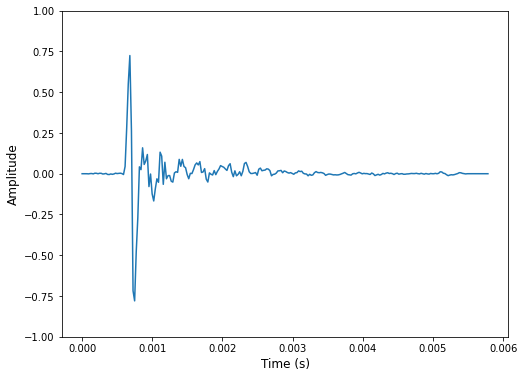

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(t, temp[0][0])
plt.xlabel("Time (s)", fontsize = 12)
plt.ylabel("Amplitude", fontsize = 12)
plt.ylim([-1,1])
plt.show()

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=256
  n_fft, y.shape[-1]


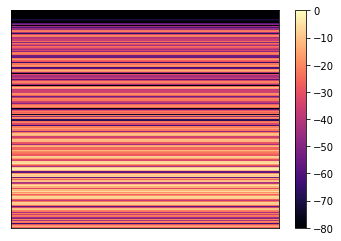

In [ ]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

import librosa.display

plt.figure()
librosa.display.specshow(S_db)
plt.colorbar()

In [ ]:
def pre_process_audio_mel_t(audio, sample_rate=44100, n_fft = 1024):
  mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft = n_fft)
  mel_db = (librosa.power_to_db(mel_spec, ref=np.max) + 40) / 40
  return mel_db.T

In [ ]:
mel_spec = librosa.feature.melspectrogram(y=temp[0][0], sr=44100, n_fft = 100000)
mel_spec = mel_spec.T
mel_spec

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=100000 is too small for input signal of length=256
  n_fft, y.shape[-1]


array([[4.44374591e+00, 5.03339602e+01, 1.88245330e+02, 1.96289874e-08,
        4.64070538e+02, 6.35759652e+02, 6.78894583e-08, 7.64630377e+02,
        4.43466947e+02, 2.54628234e-07, 8.71502229e+01, 1.61211970e+01,
        8.23976775e+01, 1.41932347e+03, 3.04415123e-04, 3.11289502e+02,
        8.59665854e+02, 4.60813176e-07, 3.33224048e+02, 3.65628345e+02,
        7.37187646e-08, 2.15850672e+02, 9.79816626e+01, 2.49796754e-08,
        1.57585908e+00, 1.77504405e-01, 7.12643128e+01, 5.78144410e+02,
        3.55757311e-06, 6.51718445e+02, 1.38038695e+03, 6.69768251e-08,
        1.56610510e+03, 1.03338651e+03, 2.27721674e+02, 2.28568537e+03,
        1.69953873e-07, 7.60395464e+02, 2.17785603e+02, 9.31551527e+01,
        5.64991640e+01, 7.17723400e+00, 4.70241953e+00, 1.80330830e+02,
        7.48808991e+01, 5.03060417e+02, 1.96235101e+02, 5.06970090e+02,
        6.75411829e+02, 5.83418674e+02, 1.76616388e+03, 1.13102670e+03,
        1.04668975e+03, 1.25356841e+03, 3.30033027e+02, 7.753859

In [ ]:
pre_process_audio_mel_t(temp[0][0], n_fft = 256)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


array([[-1.        , -1.        , -1.        , -1.        ,  0.29143851,
         0.31597727, -1.        , -1.        , -1.        , -1.        ,
         0.44788337,  0.2236583 , -1.        , -1.        , -1.        ,
         0.69313515,  0.76943167, -1.        , -1.        , -1.        ,
        -1.        ,  0.62178944,  0.48754273, -1.        , -1.        ,
        -1.        ,  0.61769979,  0.7559525 , -1.        , -1.        ,
        -1.        , -1.        ,  0.89041304,  0.78628923, -1.        ,
        -1.        , -1.        ,  0.82979109,  0.5960733 , -1.        ,
        -1.        , -0.25768937, -0.36278806, -1.        ,  0.40173898,
         0.7692624 , -1.        , -1.        ,  0.84879631,  0.73224436,
        -1.        ,  0.86734046,  0.73985523,  0.34032237,  0.69921378,
        -1.        ,  0.67678342,  0.65836581,  0.74610057,  0.88306006,
         0.62794741,  0.93197076,  0.4760567 ,  0.82691211,  0.43970895,
         0.63141924,  0.81834004,  0.87914459,  0.9